# Regression Analysis And ML classifier (4th and 5th Part)

In [7]:
!pip install seaborn
!pip install pandas tabulate
!pip install statsmodels   # Everytime at new running I rerun this line I thought it is a library and downloaded

# Regression Analysis

 **Preparing Dataset:**
* Uploading Dataset from this link: https://www.kaggle.com/datasets/mouashmawy/COVID-19-Case-Surveillance
* Ensuring the date format to prevent errors and extracting period
* Choose needed columns for analysis (sex , age group , ICU , hospitilized , death , month)
* Aggregating the columns by month to group them and resetting index 
* Dummy Variables for age group and sex  

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Loading dataset
data = pd.read_csv('../input/covid-19-case-surveillance/data.csv')

# Needed columns for analysis
relevant_columns = ['sex', 'age_group', 'icu_yn', 'hosp_yn', 'death_yn', 'case_month']
# Dropping Missing Values and removing white spaces
data[relevant_columns] = data[relevant_columns].applymap(lambda x: x.strip() if isinstance(x, str) else x)
data[relevant_columns] = data[relevant_columns].replace(['Unknown', 'unknown' , 'Missing' , 'N/A' , 'NA' , 'NaN' , ' ' , 'Other' ,  'other'], np.nan)
data = data[relevant_columns].dropna()

# Aggregate data by month
monthly_data = data.groupby('case_month').agg({
    'sex': lambda x: x.value_counts(normalize=True).to_dict(),
    'age_group': lambda x: x.value_counts(normalize=True).to_dict(),
    'icu_yn': lambda x: x.value_counts(normalize=True).get('Yes', 0),
    'hosp_yn': lambda x: x.value_counts(normalize=True).get('Yes', 0),
    'death_yn': lambda x: x.value_counts(normalize=True).get('Yes', 0)
}).reset_index()

sex_data = pd.json_normalize(monthly_data.pop('sex'))
age_group_data = pd.json_normalize(monthly_data.pop('age_group'))
monthly_data = monthly_data.join(sex_data, rsuffix = 'sex' )
monthly_data = monthly_data.join(age_group_data, rsuffix = 'age_group')

# Display the monthly aggregated data
monthly_data.head()

/tmp/ipykernel_35/3330528442.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../input/covid-19-case-surveillance/data.csv')
/tmp/ipykernel_35/3330528442.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[relevant_columns] = data[relevant_columns].applymap(lambda x: x.strip() if isinstance(x, str) else x)


,case_month,icu_yn,hosp_yn,death_yn,Female,Male,65+ years,18 to 49 years,50 to 64 years,0 - 17 years
0,2020-02,0.833333,1.000000,0.833333,0.666667,0.333333,0.833333,0.166667,NaN,NaN
1,2020-03,0.174456,0.385778,0.139404,0.496575,0.503425,0.212933,0.477438,0.302780,0.006849
2,2020-04,0.114369,0.276335,0.126853,0.519229,0.480771,0.243786,0.484004,0.247241,0.024969
3,2020-05,0.075014,0.205362,0.062037,0.532373,0.467627,0.180405,0.555048,0.212635,0.051911
4,2020-06,0.042324,0.117237,0.024493,0.541709,0.458291,0.102275,0.655257,0.167350,0.075118


In [ ]:
data.head()

**Model’s coefficients and p-values Report**

In [10]:
# Define the independent variables (X) and the dependent variable (y)
X = monthly_data[['Female', 'Male', '18 to 49 years', '65+ years', '50 to 64 years', '0 - 17 years', 'icu_yn', 'hosp_yn']]
y = monthly_data['death_yn']

# Checking for missing values after aggregation just for understanding 
#print("Missing values in X before dropping:")
#print(X.isnull().sum())
#print("Missing values in y before dropping:")
#print(y.isnull().sum())

# Drop rows with any missing values in X or y
X = X.dropna()
y = y.loc[X.index]  # Ensure y has the same index as X after dropping rows

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the model's summary
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               death_yn   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     15.49
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.84e-09
Time:                        14:27:06   Log-Likelihood:                 134.03
No. Observations:                  49   AIC:                            -254.1
Df Residuals:                      42   BIC:                            -240.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0527      0.012      4.

**Extracting P-values and Coefficients**

In [11]:
from tabulate import tabulate
# Extract coefficients and p-values
coefficients = model.params
p_values = model.pvalues
# Create a DataFrame
results_df = pd.DataFrame({'Coefficients': coefficients,'P-values': p_values})
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----------------+----------------+-------------+
|                |   Coefficients |    P-values |
|----------------+----------------+-------------|
| const          |      0.0526515 | 4.21235e-05 |
| Female         |     -0.140092  | 0.0425804   |
| Male           |      0.192744  | 0.0106233   |
| 18 to 49 years |     -0.13987   | 0.00319383  |
| 65+ years      |     -0.0875886 | 0.0614355   |
| 50 to 64 years |      0.361585  | 0.00010082  |
| 0 - 17 years   |     -0.0814745 | 0.0141653   |
| icu_yn         |      0.544478  | 0.00798378  |
| hosp_yn        |     -0.172217  | 0.0737599   |
+----------------+----------------+-------------+


**Good and Bad Predictors**

In [15]:
good_predictors = p_values[p_values < 0.05].index.tolist()
bad_predictors = p_values[p_values >= 0.05].index.tolist()

# Make both lists the same length by filling the shorter list with white spaces
max_length = max(len(good_predictors), len(bad_predictors))
good_predictors += [''] * (max_length - len(good_predictors))
bad_predictors += [''] * (max_length - len(bad_predictors))

# Create a DataFrame
predictors_df = pd.DataFrame({
    'Good Predictors (p < 0.05)': good_predictors,
    'Bad Predictors (p >= 0.05)': bad_predictors
})

# Print the DataFrame
print("\nPredictors:\n")
print(tabulate(predictors_df, headers='keys', tablefmt='psql'))


Predictors:

+----+------------------------------+------------------------------+
|    | Good Predictors (p < 0.05)   | Bad Predictors (p >= 0.05)   |
|----+------------------------------+------------------------------|
|  0 | const                        | 65+ years                    |
|  1 | Female                       | hosp_yn                      |
|  2 | Male                         |                              |
|  3 | 18 to 49 years               |                              |
|  4 | 50 to 64 years               |                              |
|  5 | 0 - 17 years                 |                              |
|  6 | icu_yn                       |                              |
+----+------------------------------+------------------------------+


**Heatmap of Spearman Correlation**

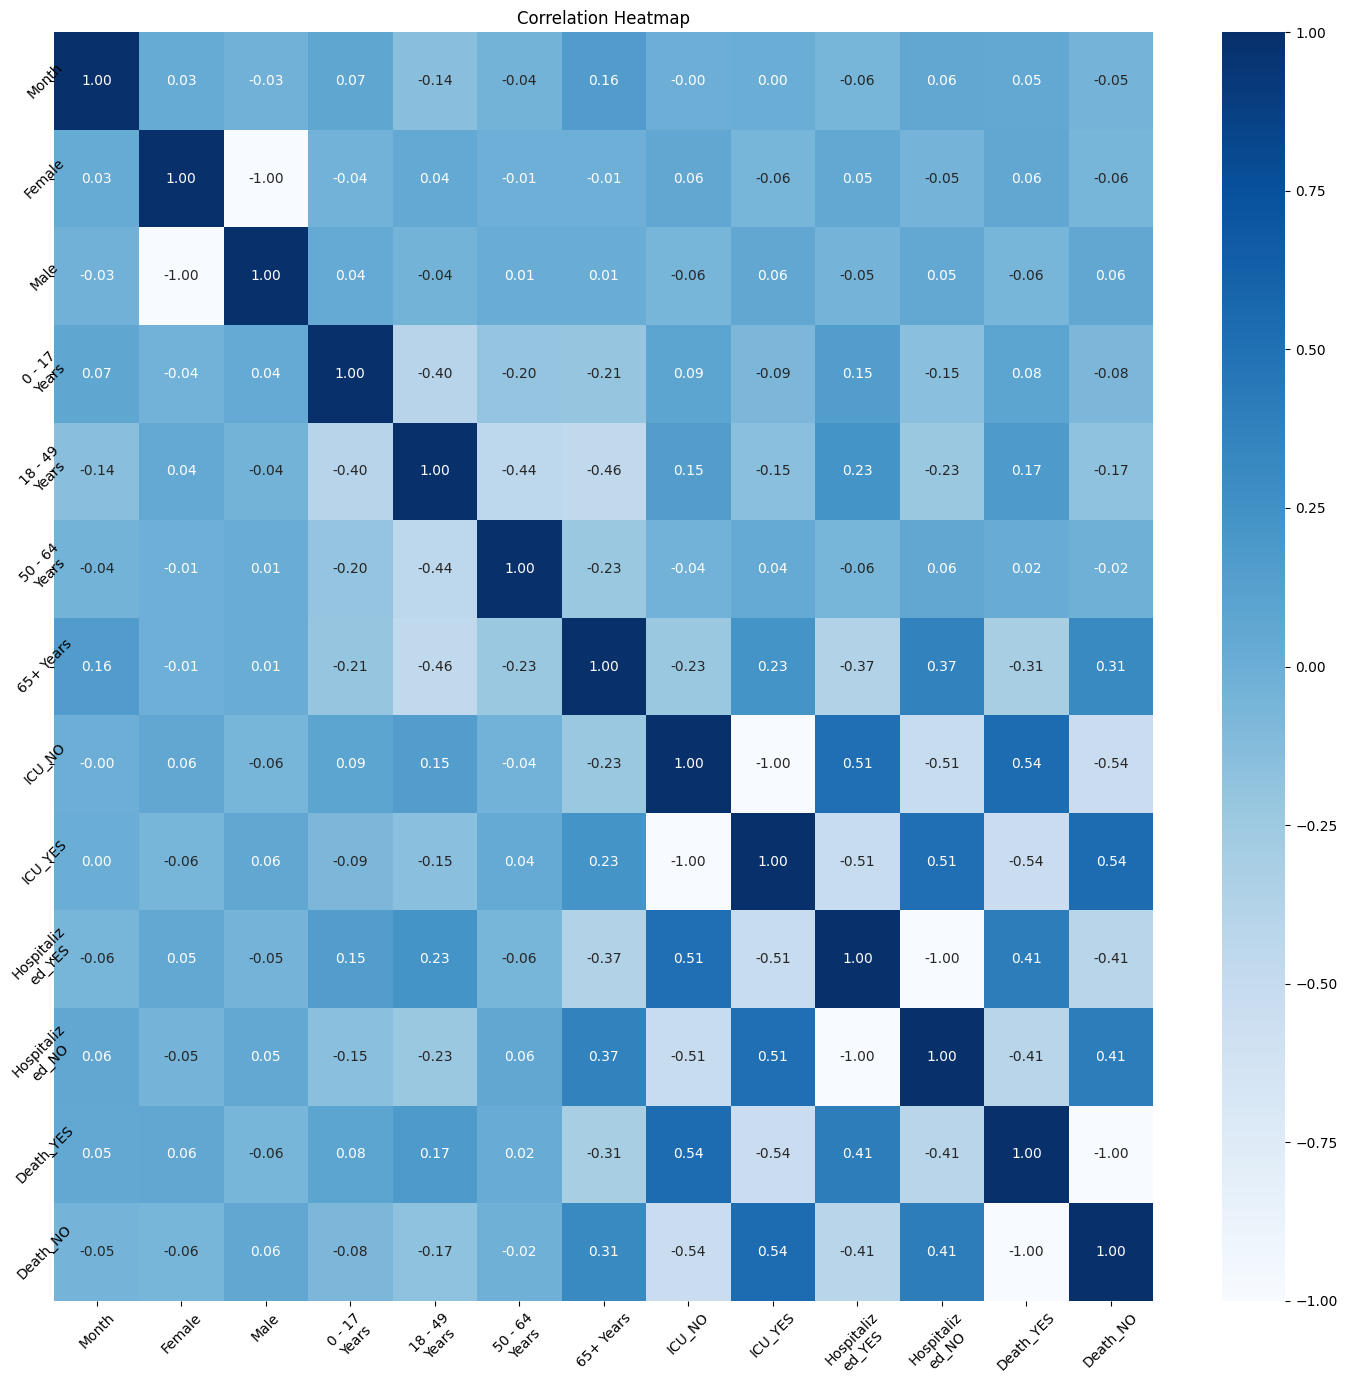

In [28]:
import seaborn as sns
data['case_month'] = pd.to_datetime(data['case_month'], format='%Y-%m')

# Encode categorical variables
data_encoded = pd.get_dummies(data)

# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

new_labels = ["Month", "Female", "Male", "0 - 17 Years", "18 - 49 Years", "50 - 64 Years", "65+ Years","ICU_NO" , "ICU_YES", "Hospitalized_YES",'Hospitalized_NO',  "Death_YES" , "Death_NO"]
wrapped_labels = wrap_labels(new_labels, width=10)
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 14))
ax = sns.heatmap(data=correlation_matrix, cmap='Blues', annot=True, fmt=".2f")
ax.set_xticklabels(wrapped_labels, rotation=45 , ha='center' , fontsize = 10  )
ax.set_yticklabels(wrapped_labels, rotation=45, ha='center', fontsize = 10 )
plt.title('Correlation Heatmap')
plt.subplots_adjust(left=0.8, right=0.9, top=0.9, bottom=0.3)
plt.tight_layout()
plt.show()

# Improving the fit and interpretability of the model

In [29]:
# Removing the intercept
X_no_intercept = X.drop(columns='const')
model_no_intercept = sm.OLS(y, X_no_intercept).fit()
model_no_intercept_summary = model_no_intercept.summary()
print(model_no_intercept_summary)

                            OLS Regression Results                            
Dep. Variable:               death_yn   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     15.49
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.84e-09
Time:                        11:53:33   Log-Likelihood:                 134.03
No. Observations:                  49   AIC:                            -254.1
Df Residuals:                      42   BIC:                            -240.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Female            -0.1050      0.065     -1.

In [30]:
# Introducing higher-order terms (e.g., squared terms)
X['icu_yn_squared'] = X['icu_yn'] ** 2
X['hosp_yn_squared'] = X['hosp_yn'] ** 2
model_with_squared_terms = sm.OLS(y, X).fit()
model_with_squared_terms_summary = model_with_squared_terms.summary()
print(model_with_squared_terms_summary)

                            OLS Regression Results                            
Dep. Variable:               death_yn   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     22.78
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.28e-12
Time:                        11:53:38   Log-Likelihood:                 147.46
No. Observations:                  49   AIC:                            -276.9
Df Residuals:                      40   BIC:                            -259.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0124      0.012     

In [31]:
# Detect and remove outliers using Cook's distance
influence = model.get_influence()
cooks = influence.cooks_distance[0]
# Define a threshold for Cook's distance
threshold = 4 / len(X)
# Identify outliers
outliers = cooks > threshold
# Remove outliers from data
X_no_outliers = X[~outliers]
y_no_outliers = y[~outliers]
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()
model_no_outliers_summary = model_no_outliers.summary()
print(model_no_outliers_summary)

                            OLS Regression Results                            
Dep. Variable:               death_yn   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     20.31
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.32e-11
Time:                        11:53:41   Log-Likelihood:                 144.25
No. Observations:                  46   AIC:                            -270.5
Df Residuals:                      37   BIC:                            -254.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0003      0.014     

# Bonus Task

**The data was filtered from any misssing values** 

In [4]:
import pandas as pd
import numpy as np
data_bonus = pd.read_csv('../input/covid-19-case-surveillance/data.csv')
data_bonus.replace(['Unknown', 'unknown' , 'Missing' , 'N/A' , 'NA' , 'NaN' , ' ' , 'Other' ,  'other'], np.nan)
data_bonus = data_bonus.dropna()

/tmp/ipykernel_35/1397415727.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_bonus = pd.read_csv('../input/covid-19-case-surveillance/data.csv')


**Random Forest Classifier**

Importing all the needed libraries for importing the chosen classifier and other needed libraries for preparing the data for training and testing. Also, importing libraries needed for showing the results. 

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer  # for prepairing the categorical dataset 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# target variable and features
target = 'death_yn'
features = data.columns.drop(target)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Define the preprocessing for numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features),('cat', categorical_transformer, categorical_features)])

# Create a pipeline that combines the preprocessor with the classifier
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42))])

# Train the classifier
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

              precision    recall  f1-score   support

          No       0.98      0.99      0.98     68955
         Yes       0.61      0.50      0.55      2596

    accuracy                           0.97     71551
   macro avg       0.80      0.74      0.77     71551
weighted avg       0.97      0.97      0.97     71551

Accuracy: 0.97


**Why Random Forest Classifier?**
### Versatility:
- Handle both numerical and categorical data.
- Capture non-linear relationships and interactions between features.

### Performance:
- Provide good performance out of the box with fewer hyperparameters to tune.
- Less prone to overfitting compared to single decision trees due to aggregation of multiple trees.

### Feature Importance:
- Offer insights into feature importance, highlighting influential features.
- Useful in domains like healthcare to identify key risk factors.

### Robustness:
- Robust to outliers and noise, as they average over multiple trees.
- Less sensitive to overfitting, suitable for complex datasets.

### Ease of Use:
- Require minimal data preprocessing compared to other algorithms like logistic regression or SVMs.
- Handle missing values and do not require feature scaling.

### Parallelization:
- Can be parallelized effectively, making them suitable for large datasets.